In [15]:
# try to mount google colab
import os
try:
  from google.colab import drive
  drive.mount('/content/drive')
  cur_dir = "/content/drive/MyDrive/ws/prj/adv_ds_2310/Lab05_Models/PimaIndia/preprocessing"
except:
  cur_dir = "."
  pass
cur_dir = os.path.abspath(cur_dir)
os.chdir(cur_dir)
print(f'cur_dir: {cur_dir} \n --> {os.path.abspath(".")}')


cur_dir: c:\HK1-2025-2026\ML\Team_SGU_25_ML_Fundamental\Team_SGU_25_ML_Fundamental\dntai_log_exps\PimaIndia\preprocessing 
 --> c:\HK1-2025-2026\ML\Team_SGU_25_ML_Fundamental\Team_SGU_25_ML_Fundamental\dntai_log_exps\PimaIndia\preprocessing


# Tiền xử lý dữ liệu (Data Preprocessing) – Pima India
Đây là phần quan trọng nhất, quyết định chất lượng mô hình. Cấu trúc theo 5 bước như bạn yêu cầu, nhưng điều chỉnh cho bộ dữ liệu Pima:

✳️ 1. Xử lý dữ liệu thiếu (theo EDA Pima)
- Các cột đo lường có giá trị 0 không hợp lệ: `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`.
- Thay 0 → NaN, sau đó điền khuyết bằng trung vị (median) của từng cột.
- Loại bỏ dòng trùng (nếu có).

✳️ 2. Chuyển đổi dữ liệu dạng chữ → số
- Dataset Pima không có cột dạng chuỗi (trừ khi đổi tên cột). `Outcome` đã là nhãn số 0/1.
- (Nếu tích hợp thêm thuộc tính danh mục mới, dùng `LabelEncoder`/`OneHotEncoder`).

✳️ 3. Chuẩn hóa dữ liệu (nếu cần)
- Dùng `StandardScaler()` (hoặc `MinMaxScaler()`) cho tất cả cột đầu vào, đặc biệt `Glucose`, `BMI`, `BloodPressure`, …
- Fit scaler trên tập train, transform cho cả train và test. Scaler được lưu tại `../exps/features/standard_scaler.joblib`.

✳️ 4. Loại bỏ hoặc tách đặc trưng không cần thiết
- Pima không có các cột dạng định danh như Titanic (`PassengerId`, `Name`, `Ticket`, `Cabin`).
- Có thể loại bớt các đặc trưng kém tương quan/không hữu ích nếu mô hình/EDA chỉ ra (tùy thí nghiệm).

✳️ 5. Tạo thêm đặc trưng (Feature Engineering) – gợi ý cho Pima
- `BMI_Class`: phân nhóm BMI (Underweight/Normal/Overweight/Obese) theo ngưỡng WHO.
- `Glucose_Bin`: phân nhóm glucose (ví dụ: low/normal/high) theo domain.
- `AgeGroup`: nhóm tuổi (trẻ, thanh niên, trung niên, cao tuổi).
- `Insulin_to_BMI`: tỷ lệ Insulin/BMI (nếu có ý nghĩa, sau khi xử lý 0→NaN và impute).

Lưu ý triển khai
- Các bước 1–3 đã được mã hóa trong notebook: cleaning → split (stratify) → scaling → lưu artifacts.
- Bạn có thể chèn thêm cell để hiện thực các đặc trưng ở bước 5 (tùy mục tiêu bài toán/model).


# Pima India Diabetes - Preprocessing

Liên kết trực tiếp với `eda/eda.ipynb`:
- Dataset: `../data/diabetes.csv`
- Target: `Outcome` (0/1), mất cân bằng (khoảng 65/35)
- Cần xử lý: giá trị 0 bất hợp lý ở các cột đo lường (Glucose, BloodPressure, SkinThickness, Insulin, BMI)
- Features quan trọng: Glucose, BMI, Age; tương quan vừa với Outcome


In [16]:
# Libraries
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
import joblib

%matplotlib inline


In [17]:
# Params and paths
seed = 42
exps_dir = "../exps"
os.makedirs(exps_dir, exist_ok=True)
save_dir = f"{exps_dir}/features"
os.makedirs(save_dir, exist_ok=True)

# Load dataset
data_path = "../data/diabetes.csv"
df_dataset = pd.read_csv(data_path)
print(df_dataset.shape)
display.display(df_dataset.head())


(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [18]:
# Cleaning based on EDA
cols_zero_nan = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
# Replace zeros with NaN for these physiological measures
df_clean = df_dataset.copy()
df_clean[cols_zero_nan] = df_clean[cols_zero_nan].replace(0, np.nan)

# Report missing counts
print("Missing after zero->NaN:")
print(df_clean[cols_zero_nan].isna().sum())

# Impute with median
for c in cols_zero_nan:
    median_val = df_clean[c].median()
    df_clean[c].fillna(median_val, inplace=True)

# Drop duplicates if any
n_dups = df_clean.duplicated(keep=False).sum()
print(f"Duplicates: {n_dups}")
if n_dups:
    df_clean = df_clean.drop_duplicates().reset_index(drop=True)

display.display(df_clean.describe().T)


Missing after zero->NaN:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64
Duplicates: 0


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,121.656250,30.438286,44.000,99.75000,117.0000,140.25000,199.00
BloodPressure,768.0,72.386719,12.096642,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,768.0,29.108073,8.791221,7.000,25.00000,29.0000,32.00000,99.00
Insulin,768.0,140.671875,86.383060,14.000,121.50000,125.0000,127.25000,846.00
BMI,768.0,32.455208,6.875177,18.200,27.50000,32.3000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


cols_zero_nan: Một danh sách (list) chứa tên các cột mà ở đó giá trị 0 được coi là bất hợp lý. Trong thực tế, các chỉ số sinh lý như Nồng độ Glucose, Huyết áp (BloodPressure), Độ dày da (SkinThickness), nồng độ Insulin, hay chỉ số BMI không thể bằng 0 ở một người sống. Do đó, giá trị 0 ở đây rất có thể là một cách biểu diễn cho dữ liệu bị thiếu (missing data).

df_clean = df_dataset.copy(): Tạo ra một bản sao của DataFrame gốc. Đây là một thực hành rất tốt, giúp chúng ta có thể thay đổi trên df_clean mà không làm ảnh hưởng đến dữ liệu gốc df_dataset.

.replace(0, np.nan): Tìm tất cả các giá trị bằng 0 trong các cột đã chỉ định và thay thế chúng bằng np.nan (Not a Number). np.nan là định dạng chuẩn cho dữ liệu bị thiếu trong các thư viện xử lý dữ liệu của Python như Pandas và Scikit-learn

df_clean[cols_zero_nan].isna().sum(): Dòng này dùng để kiểm tra lại công việc. Nó đếm số lượng giá trị NaN (dữ liệu thiếu) trong mỗi cột sau khi đã thực hiện bước chuyển đổi ở trên.

In [19]:
# Train/Test split (stratified)
X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)
#20 test, 80 train
print(X_train.shape, X_test.shape, y_train.mean(), y_test.mean())

# Save raw splits
split_dir = f"{exps_dir}/data"
os.makedirs(split_dir, exist_ok=True)
X_train.to_csv(f"{split_dir}/X_train.csv", index=False)
X_test.to_csv(f"{split_dir}/X_test.csv", index=False)
y_train.to_csv(f"{split_dir}/y_train.csv", index=False)
y_test.to_csv(f"{split_dir}/y_test.csv", index=False)


(614, 8) (154, 8) 0.3485342019543974 0.35064935064935066


In [20]:
# Scaling
num_cols = X_train.columns.tolist()
scaler_std = StandardScaler()
scaler_std.fit(X_train[num_cols])

X_train_std = X_train.copy()
X_test_std  = X_test.copy()
X_train_std[num_cols] = scaler_std.transform(X_train[num_cols])
X_test_std[num_cols]  = scaler_std.transform(X_test[num_cols])

# Save scaler and columns
joblib.dump(scaler_std, f"{save_dir}/standard_scaler.joblib")
np.savez(f"{save_dir}/feature_columns.npz", columns=num_cols)

# Save processed datasets
X_train_std.to_csv(f"{split_dir}/X_train_std.csv", index=False)
X_test_std.to_csv(f"{split_dir}/X_test_std.csv", index=False)
print("Saved scaler and standardized splits.")


Saved scaler and standardized splits.


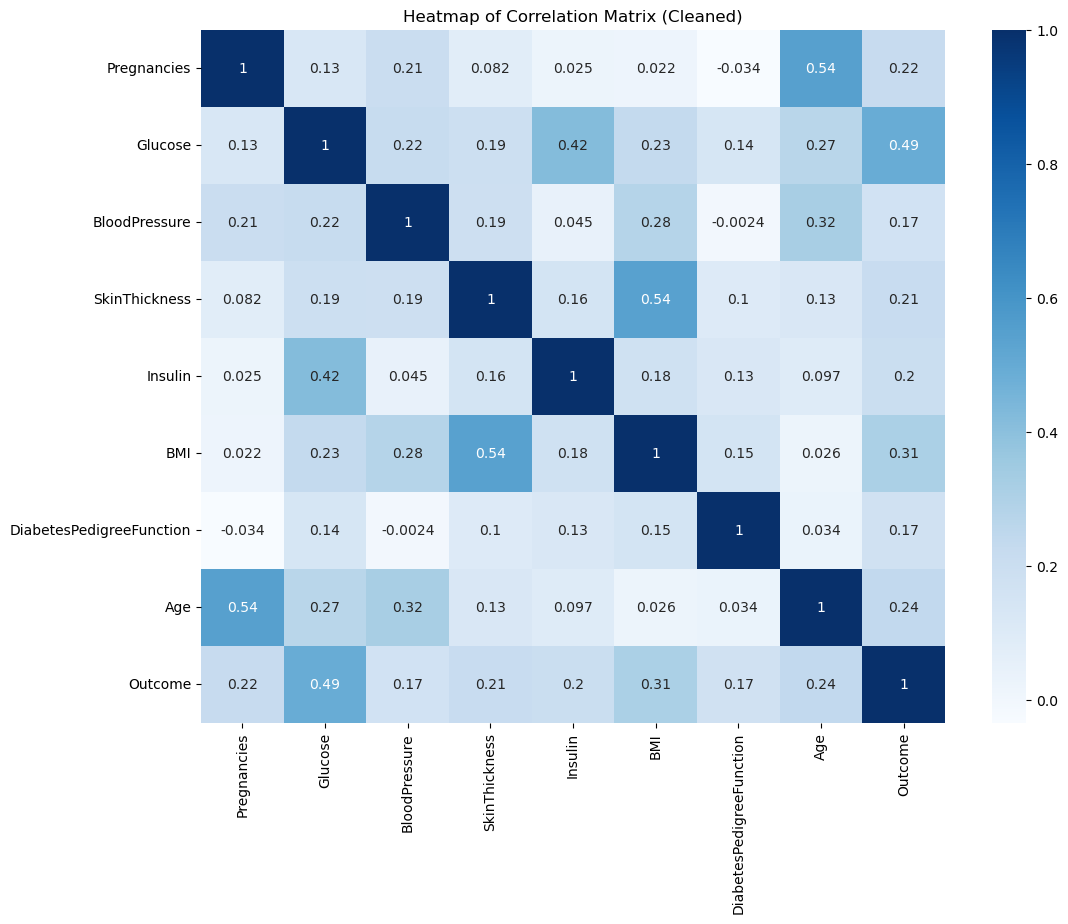

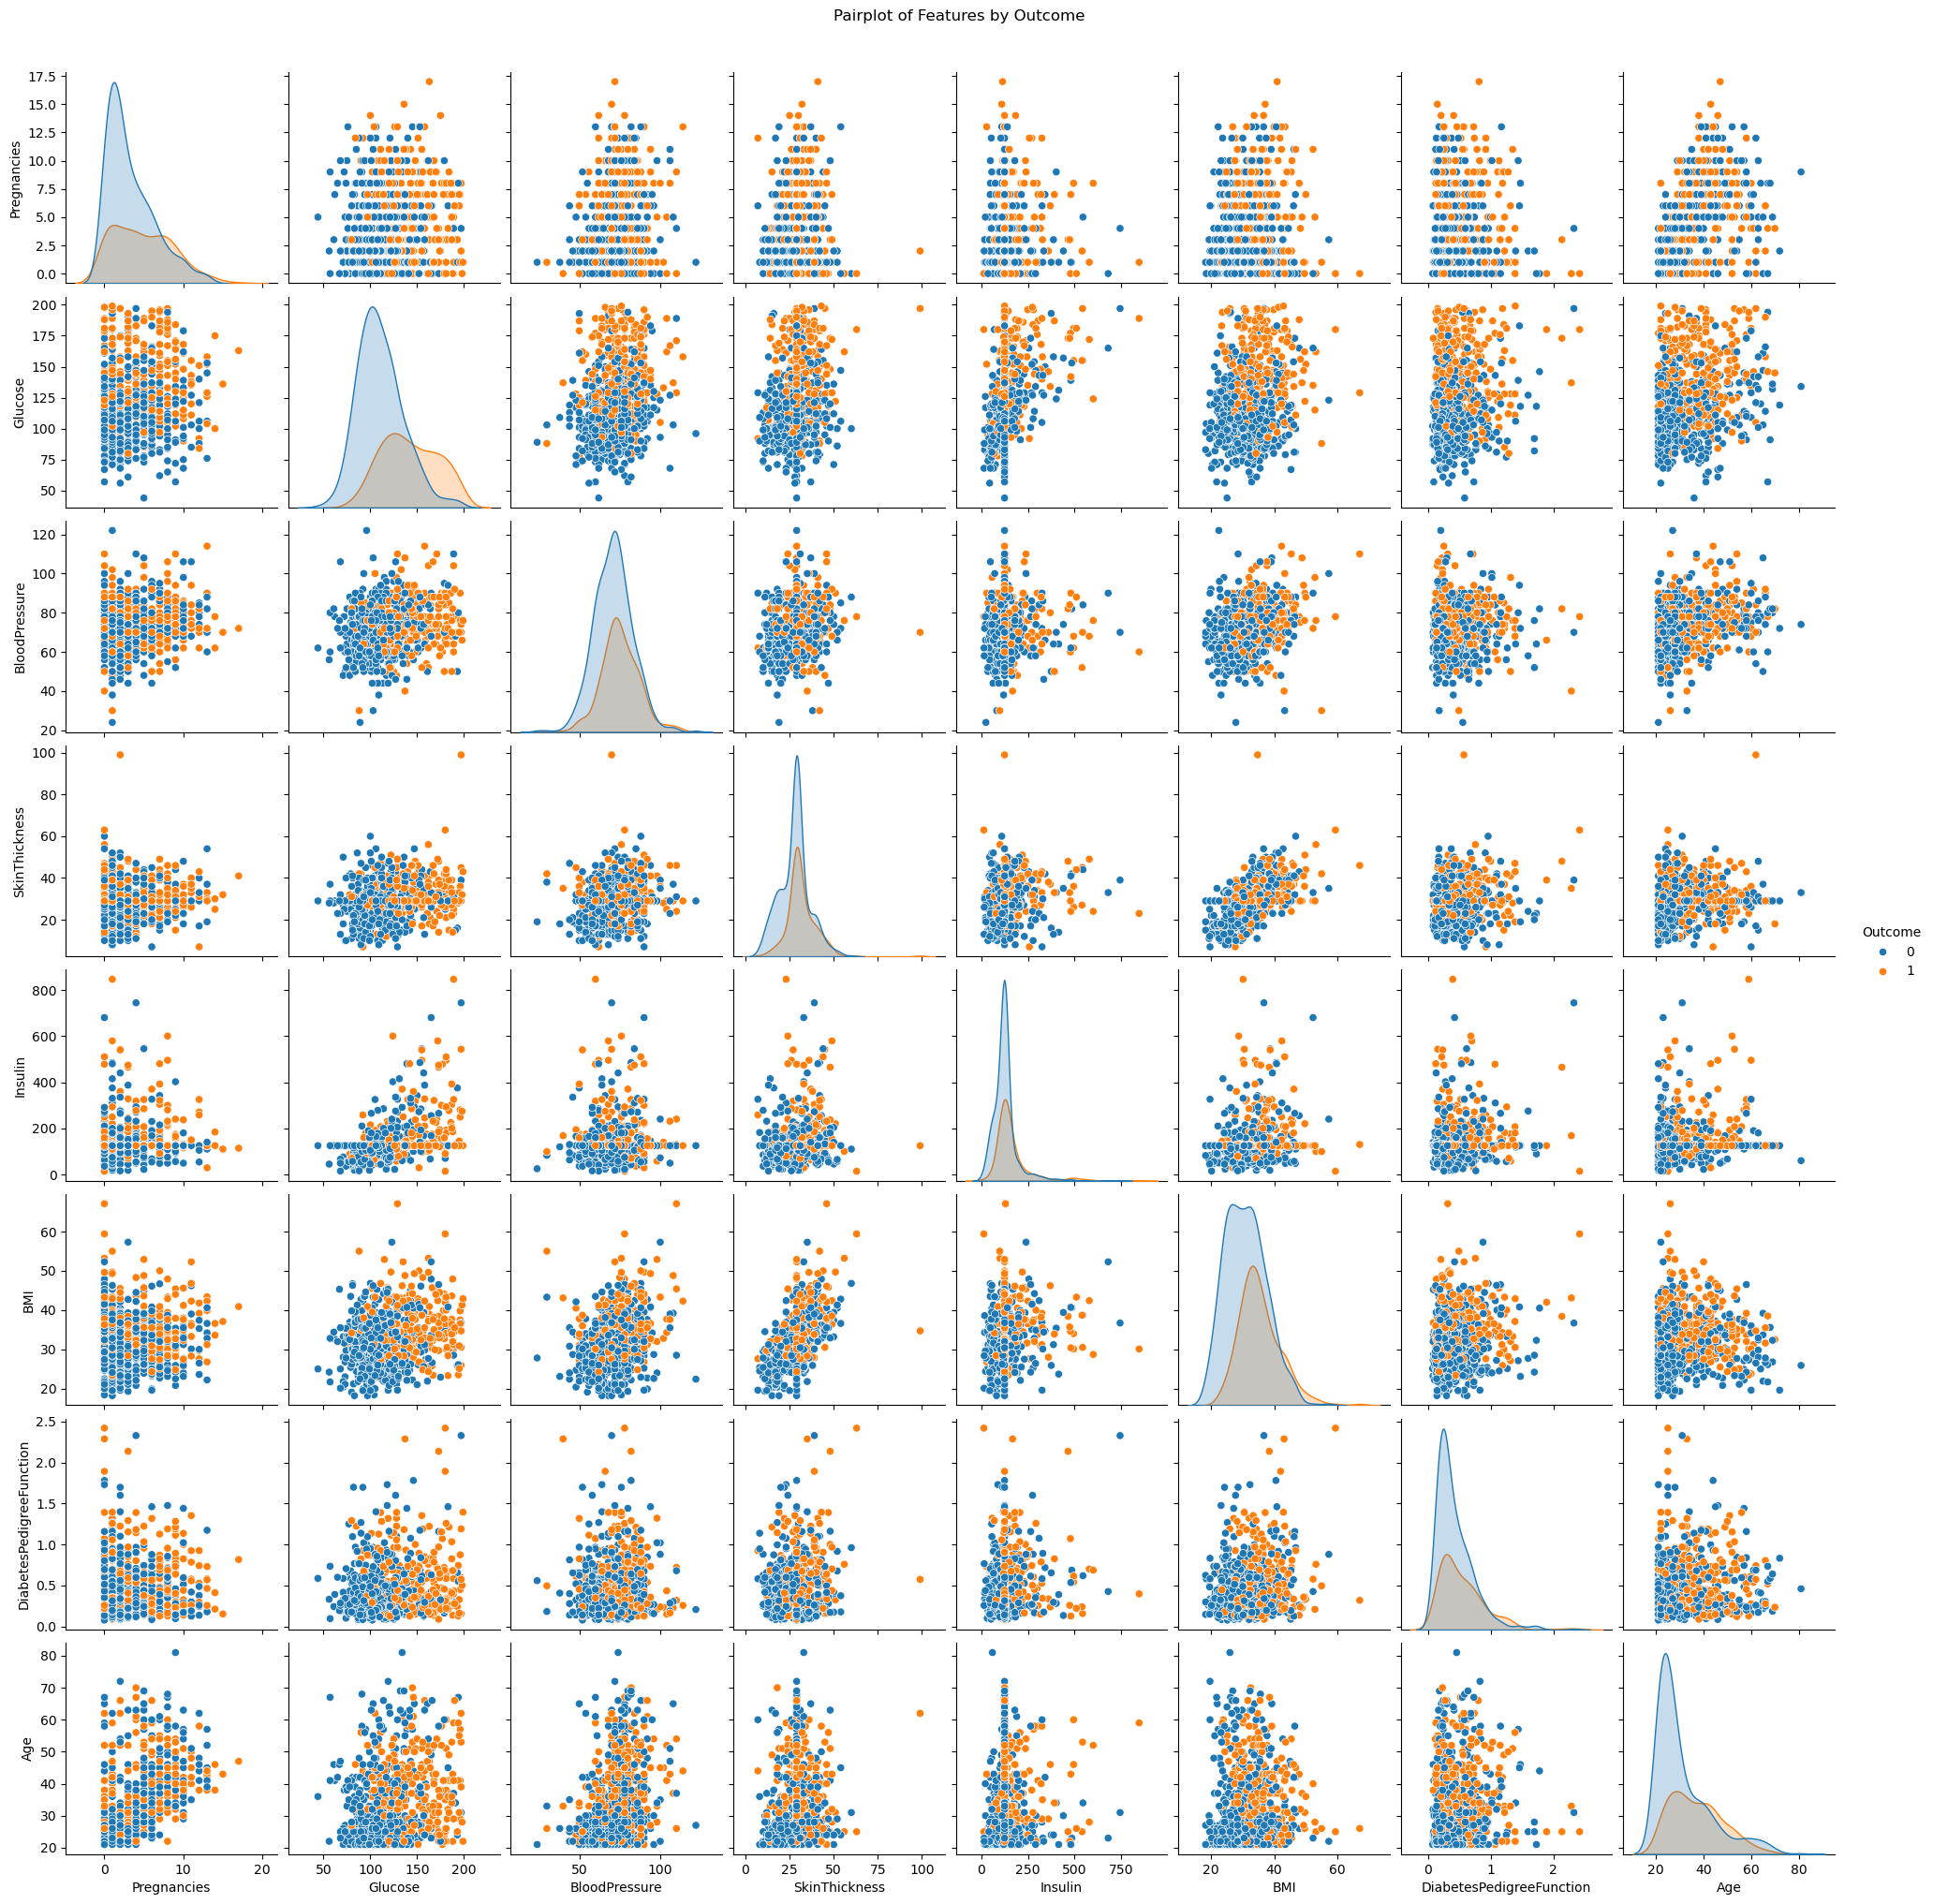

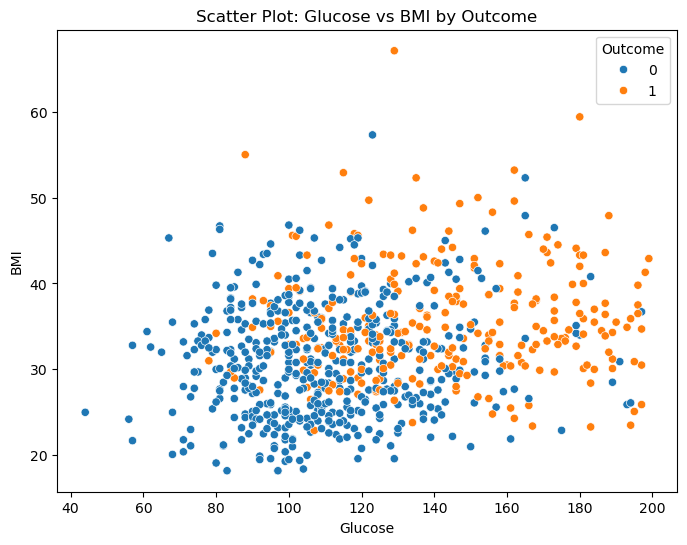

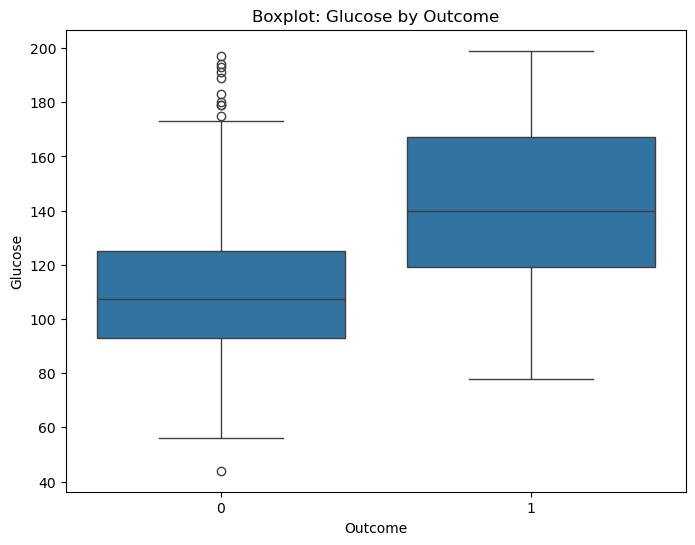

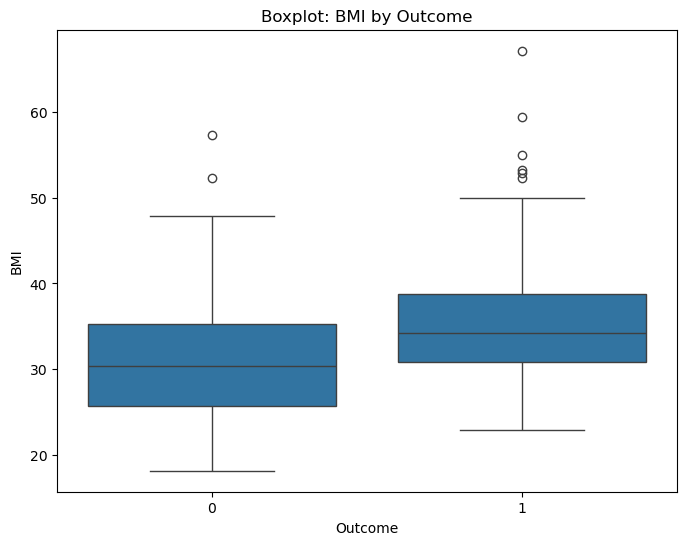

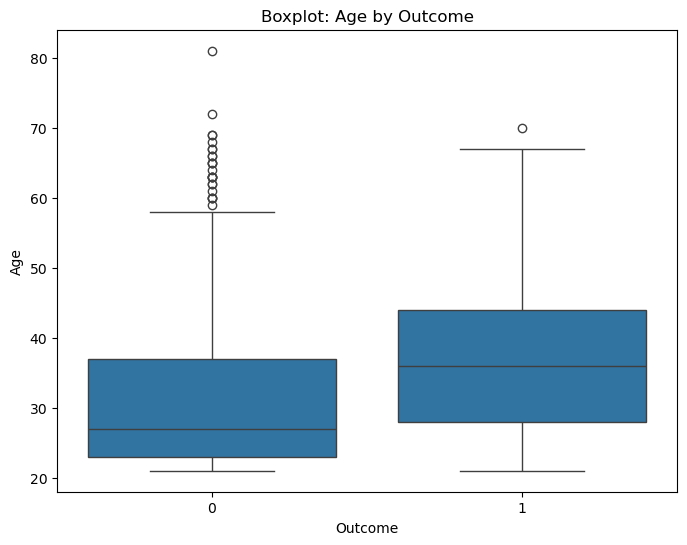

In [21]:
# Visualizations aligned with EDA (Outcome-based)
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap correlation (cleaned)
plt.figure(figsize=(12, 9))
sns.heatmap(df_clean.corr(), cmap='Blues', annot=True)
plt.title('Heatmap of Correlation Matrix (Cleaned)')
plt.show()

# Pairplot by Outcome
sns.pairplot(df_clean, hue='Outcome', diag_kind='kde')
plt.suptitle('Pairplot of Features by Outcome', y=1.02)
plt.show()

# Scatter (Glucose vs BMI)
plt.figure(figsize=(8,6))
sns.scatterplot(x='Glucose', y='BMI', hue='Outcome', data=df_clean)
plt.title('Scatter Plot: Glucose vs BMI by Outcome')
plt.show()

# Boxplots for key features
for col in ['Glucose','BMI','Age']:
    plt.figure(figsize=(8,6))
    sns.boxplot(x='Outcome', y=col, data=df_clean)
    plt.title(f'Boxplot: {col} by Outcome')
    plt.show()


In [22]:
# Missing data handling (detailed)
import numpy as np
import pandas as pd
from IPython import display

# Ensure df_dataset exists; if not, load it
try:
    df_dataset
except NameError:
    df_dataset = pd.read_csv("../data/diabetes.csv")

# 1) Report original missing (note: Pima uses 0 as missing for some columns)
print("Original missing (NaN) counts:")
display.display(df_dataset.isna().sum())

# 2) Columns where 0 is not physiologically valid -> treat as missing
zero_as_missing_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Counts of zeros before
print("Zeros count before (treated as missing):")
display.display((df_dataset[zero_as_missing_cols] == 0).sum())

# Convert 0 -> NaN for the specified columns
df_missing = df_dataset.copy()
df_missing[zero_as_missing_cols] = df_missing[zero_as_missing_cols].replace(0, np.nan)

# 3) Report missing after conversion
print("Missing (NaN) counts AFTER converting 0->NaN for key columns:")
display.display(df_missing.isna().sum())

# 4) Impute with median per column (robust to outliers)
for c in zero_as_missing_cols:
    median_val = df_missing[c].median()
    df_missing[c].fillna(median_val, inplace=True)

# 5) Optional: drop duplicates
num_dup = df_missing.duplicated(keep=False).sum()
print(f"Duplicate rows detected: {num_dup}")
if num_dup:
    df_missing = df_missing.drop_duplicates().reset_index(drop=True)

# 6) Sanity check after imputation
print("Missing (NaN) counts AFTER imputation:")
display.display(df_missing.isna().sum())

# 7) Preview summary statistics to ensure reasonable distributions after impute
print("Describe (key columns) AFTER imputation:")
display.display(df_missing[zero_as_missing_cols].describe().T)

# 8) Persist cleaned dataset to use in subsequent steps
clean_path = "../exps/data/clean_full.csv"
import os
os.makedirs("../exps/data", exist_ok=True)
df_missing.to_csv(clean_path, index=False)
print(f"Saved cleaned dataset to: {clean_path}")


Original missing (NaN) counts:


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Zeros count before (treated as missing):


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

Missing (NaN) counts AFTER converting 0->NaN for key columns:


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Duplicate rows detected: 0
Missing (NaN) counts AFTER imputation:


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Describe (key columns) AFTER imputation:


,count,mean,std,min,25%,50%,75%,max
Glucose,768.0,121.656250,30.438286,44.0,99.75,117.0,140.25,199.0
BloodPressure,768.0,72.386719,12.096642,24.0,64.00,72.0,80.00,122.0
SkinThickness,768.0,29.108073,8.791221,7.0,25.00,29.0,32.00,99.0
Insulin,768.0,140.671875,86.383060,14.0,121.50,125.0,127.25,846.0
BMI,768.0,32.455208,6.875177,18.2,27.50,32.3,36.60,67.1


Saved cleaned dataset to: ../exps/data/clean_full.csv


## Chức năng các file đầu ra (Outputs & Artifacts)

Thư mục: `dntai_log_exps/PimaIndia/exps/data/`
- `X_train.csv`: Features tập train sau khi làm sạch (chưa chuẩn hóa).
- `X_test.csv`: Features tập test sau khi làm sạch (chưa chuẩn hóa).
- `y_train.csv`: Nhãn `Outcome` tương ứng với `X_train.csv`.
- `y_test.csv`: Nhãn `Outcome` tương ứng với `X_test.csv`.
- `X_train_std.csv`: Features tập train sau khi chuẩn hóa bằng `StandardScaler` (mean=0, std=1).
- `X_test_std.csv`: Features tập test sau khi chuẩn hóa bằng `StandardScaler`.

Thư mục: `dntai_log_exps/PimaIndia/exps/features/`
- `standard_scaler.joblib`: Bộ biến đổi `StandardScaler` đã fit trên `X_train`; dùng lại để transform dữ liệu mới/inference.
- `feature_columns.npz`: Danh sách cột (thứ tự features) dùng để đảm bảo transform đúng cột, đúng thứ tự khi deploy.

Tham chiếu khác:
- `../data/diabetes.csv`: Dữ liệu gốc đầu vào.
- Notebook này (`preprocessing.ipynb`): Thực hiện làm sạch, chia dữ liệu, chuẩn hóa, lưu artifacts và trực quan hóa gắn với EDA.
- `../eda/eda.ipynb`: Notebook phân tích khám phá dữ liệu (EDA) làm cơ sở cho các quyết định xử lý.


# Hướng dẫn chi tiết Preprocessing (gắn với EDA)

Tài liệu này giải thích chi tiết các bước xử lý trong notebook, dựa trên kết quả phân tích ở `eda/eda.ipynb`.

## 1) Liên kết với EDA
- **Dataset**: `../data/diabetes.csv` (Pima Indians Diabetes)
- **Target**: `Outcome` (0 = không tiểu đường, 1 = tiểu đường) – dữ liệu **mất cân bằng** (~65%/35%).
- **Vấn đề dữ liệu** (từ EDA): Các cột đo lường có nhiều giá trị bằng 0 không hợp lệ: `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`.
- **Features quan trọng** (từ tương quan + biểu đồ): `Glucose`, `BMI`, `Age`.

## 2) Nạp dữ liệu
- Đọc `../data/diabetes.csv` vào `df_dataset` để đảm bảo dùng đúng nguồn như EDA.

## 3) Làm sạch dữ liệu (Cleaning)
- Cột sinh lý không thể bằng 0 trong ngữ cảnh đo lường thực: `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`.
- Bước làm sạch:
  1) Thay giá trị 0 → `NaN` cho 5 cột trên.
  2) **Điền khuyết** bằng trung vị (median) trên tập toàn bộ (đơn giản, ổn định trước khi chia dữ liệu). Nếu muốn nghiêm ngặt hơn, bạn có thể chuyển sang impute theo train-set để tránh leakage.
  3) Loại bỏ dòng trùng (nếu có).

Lợi ích: loại bỏ giá trị không hợp lệ, giảm thiên lệch do ngoại lệ khi huấn luyện.

## 4) Chia dữ liệu Train/Test (Stratified)
- Dùng `train_test_split` với `stratify=y` để **giữ tỉ lệ lớp** giữa train và test.
- Tỉ lệ đang dùng: 80% train, 20% test. Có thể đổi tùy nhu cầu (70/30, 75/25,…).
- Lưu các file split: `X_train.csv`, `X_test.csv`, `y_train.csv`, `y_test.csv` vào `../exps/data/` để tái sử dụng.

## 5) Chuẩn hóa đặc trưng (Scaling)
- Dùng `StandardScaler` (chuẩn hóa về mean=0, std=1) trên tất cả cột đầu vào.
- Fit trên `X_train`, sau đó transform cho cả `X_train` và `X_test`.
- Lưu `standard_scaler.joblib` và danh sách cột `feature_columns.npz` vào `../exps/features/` để dùng lại trong inference/pipeline.
- Lưu bộ dữ liệu đã chuẩn hóa: `X_train_std.csv`, `X_test_std.csv`.

Gợi ý: Nếu mô hình nhạy với thang đo (SVM, KNN, Logistic Regression), StandardScaler rất hữu ích. Với cây/boosting, tác động ít hơn nhưng vẫn nên chuẩn hóa nếu pipeline chung.

## 6) Trực quan hóa (Visualization) gắn với Outcome
- **Heatmap** ma trận tương quan của dữ liệu đã làm sạch (`df_clean`) để kiểm tra mối quan hệ tuyến tính giữa các thuộc tính.
- **Pairplot** với `hue='Outcome'` để xem phân tách lớp trên từng cặp features.
- **Scatter** `Glucose` vs `BMI` theo `Outcome` (2 đặc trưng quan trọng).
- **Boxplot** cho `Glucose`, `BMI`, `Age` theo `Outcome` để so sánh phân bố giữa hai lớp.

Mục tiêu: đối chiếu nhanh với quan sát ở EDA, đảm bảo preprocessing không phá vỡ phân bố và mối tương quan quan trọng.

## 7) Artifacts/Outputs
- `../exps/data/`: các file train/test (thô) và bản chuẩn hóa để theo dõi, dùng cho huấn luyện.
- `../exps/features/`: scaler và danh sách cột.

## 8) Tiếp theo (tùy chọn)
- Xử lý mất cân bằng lớp (VD: `SMOTE`, `RandomUnderSampler`, `BalancedClassWeight`).
- Feature engineering (tạo tỷ lệ, tương tác, binning theo domain).
- Cross-validation và tracking kết quả (MLflow/Weights & Biases).

Ghi chú: Nếu bạn muốn chuyển sang impute “theo chuẩn” (fit median trên train, dùng cho test), có thể tách bước impute vào pipeline sau khi chia train/test để tránh data leakage.
